In [1]:
### ---este entrena con toda la shit, no le saca dimensionalidad con canaritos, así que sería el input para otra notebook
import os
import random

# Definir parámetros
PARAM = {}
PARAM["experimento"] = "seg-015"
PARAM["semilla_primigenia"] = 878787

# Fijar semilla
random.seed(PARAM["semilla_primigenia"])

# Definir rutas
base_path = "/content/buckets/b1/exp/Workflow"
os.chdir(base_path)

experimento_folder = PARAM["experimento"]
os.makedirs(experimento_folder, exist_ok=True)

os.chdir(f"/content/buckets/b1/exp/Workflow/{experimento_folder}")

In [2]:
import polars as pl
# === Lectura del dataset ===
df = pl.read_csv(
    "~/buckets/b1/datasets/competencia_02_crudo.csv.gz",
    infer_schema_length=10000,
    skip_rows_after_header=1  # si la segunda fila tiene tipos (i64, f64, etc.)
)

In [3]:
dataset = df

In [4]:
# Calculo el periodo0 consecutivo
dsimple = dataset.select([
    pl.int_range(pl.len()).alias("pos"),
    pl.col("numero_de_cliente"),
    ((pl.col("foto_mes") // 100) * 12 + pl.col("foto_mes") % 100).alias("periodo0")
])

# Ordeno
dsimple = dsimple.sort(["numero_de_cliente", "periodo0"])

# Calculo topes
periodo_ultimo = dsimple["periodo0"].max()
periodo_anteultimo = periodo_ultimo - 1

# Calculo los leads de orden 1 y 2
dsimple = dsimple.with_columns([
    pl.col("periodo0").shift(-1).over("numero_de_cliente").alias("periodo1"),
    pl.col("periodo0").shift(-2).over("numero_de_cliente").alias("periodo2")
])

# Inicializo clase_ternaria con None
dsimple = dsimple.with_columns(
    pl.lit(None).cast(pl.Utf8).alias("clase_ternaria")
)

# Assign most common class values = "CONTINUA"
dsimple = dsimple.with_columns(
    pl.when(pl.col("periodo0") < periodo_anteultimo)
    .then(pl.lit("CONTINUA"))
    .otherwise(pl.col("clase_ternaria"))
    .alias("clase_ternaria")
)

# Calculo BAJA+1
dsimple = dsimple.with_columns(
    pl.when(
        (pl.col("periodo0") < periodo_ultimo) &
        (pl.col("periodo1").is_null() | (pl.col("periodo0") + 1 < pl.col("periodo1")))
    )
    .then(pl.lit("BAJA+1"))
    .otherwise(pl.col("clase_ternaria"))
    .alias("clase_ternaria")
)

# Calculo BAJA+2
dsimple = dsimple.with_columns(
    pl.when(
        (pl.col("periodo0") < periodo_anteultimo) &
        (pl.col("periodo0") + 1 == pl.col("periodo1")) &
        (pl.col("periodo2").is_null() | (pl.col("periodo0") + 2 < pl.col("periodo2")))
    )
    .then(pl.lit("BAJA+2"))
    .otherwise(pl.col("clase_ternaria"))
    .alias("clase_ternaria")
)

# Pego el resultado en el dataset original y grabo
dsimple = dsimple.sort("pos")
dataset = dataset.with_columns(
    dsimple["clase_ternaria"]
)

In [5]:
df_pl = dataset

In [6]:
# 1. Parámetros
from typing import List, Tuple

pares_meses: List[Tuple[int, int]] = [
    (201905, 201906),
    (201911, 201912),
    (202005, 202006),
    (202011, 202012),
    (202105, 202106)
]

# === 0. Preparación ===
# Aseguramos que la columna sea numérica (si no se hizo en la lectura)
# La conversión a numérico se haría solo si fuera necesario (ej. si era String).
# df_pl = df_pl.with_columns(pl.col("mpayroll").cast(pl.Float64, strict=False))

# Copiamos la columna original para inicializar mpayroll_norm
df_pl = df_pl.with_columns(
    pl.col("mpayroll").alias("mpayroll_norm")
)

# === 1. Lógica Central (Vectorización del Loop) ===

# En lugar de un bucle de Python, usaremos una expresión condicional (pl.when/then)
# que maneja todos los pares de meses simultáneamente.

# 1.1. Identificar todos los clientes válidos para TODOS los pares.

# Recolectar todos los 'mes_actual' (el mes a normalizar)
meses_actuales = [p[1] for p in pares_meses]

# Identificar a los clientes que tienen un valor NO NULO para mes_anterior Y mes_actual
# para CADA par. Luego, unir todas las IDs de cliente válidas.

clientes_validos_global: pl.Series = pl.Series([], dtype=pl.Int64)
# NOTA: Para conjuntos grandes, podrías querer refactorizar esto a una expresión
# de Polars pura que evite el bucle de Python, pero este enfoque es claro y funcional.

for mes_anterior, mes_actual in pares_meses:
    
    # 1. Clientes con mpayroll no nulo en ambos meses para ESTE par
    clientes_validos_par = (
        df_pl.filter(pl.col("foto_mes").is_in([mes_anterior, mes_actual]))
        .group_by("numero_de_cliente")
        .agg(
            # Contar cuántos valores de mpayroll no son nulos para este par de meses
            pl.col("mpayroll").filter(pl.col("foto_mes").is_in([mes_anterior, mes_actual])).drop_nulls().count().alias("n_validos")
        )
        .filter(pl.col("n_validos") == 2)
        .select("numero_de_cliente")
        .to_series()
    )
    
    # Acumular las IDs válidas
    clientes_validos_global = clientes_validos_global.append(clientes_validos_par)

# Limpiar IDs duplicadas
clientes_validos_global = clientes_validos_global.unique()


# 1.2. Aplicar la normalización condicional en una sola operación de Polars

# Generar la máscara booleana que encapsula el 'loop' y el 'mask' original:
# (foto_mes == mes_actual) & (numero_de_cliente está en la lista válida)
condicion_norm = (
    pl.col("foto_mes").is_in(meses_actuales) # Meses que deben ser normalizados
    & pl.col("numero_de_cliente").is_in(clientes_validos_global)
)

# Aplicar la normalización
df_pl = df_pl.with_columns(
    pl.when(condicion_norm)
    .then(pl.col("mpayroll_norm") * 0.7)
    .otherwise(pl.col("mpayroll_norm")) # Mantener el valor si la condición es False
    .alias("mpayroll_norm")
)

/tmp/ipykernel_5547/3488938871.py:71: DeprecationWarning: `is_in` with a collection of the same datatype is ambiguous and deprecated.
Please use `implode` to return to previous behavior.

See https://github.com/pola-rs/polars/issues/22149 for more information.
  df_pl = df_pl.with_columns(


In [7]:
# === Ordenar ===
df = df_pl.sort(["foto_mes", "clase_ternaria", "numero_de_cliente"])

In [8]:
# === Conteo por foto_mes y clase_ternaria ===
conteos = (
    df.group_by(["foto_mes", "clase_ternaria"])
      .agg(pl.count().alias("N"))
      .sort(["foto_mes", "clase_ternaria"])
)

print(conteos)


# === Mes calendario (1..12) para análisis estacional ===
df = df.with_columns((pl.col("foto_mes") % 100).alias("kmes"))

# === Normalización de ctrx_quarter según antigüedad del cliente ===
# Primero, asegurar tipo numérico
df = df.with_columns(pl.col("ctrx_quarter").cast(pl.Float64).alias("ctrx_quarter_normalizado"))

# Aplicar factores según antigüedad
df = df.with_columns(
    pl.when(pl.col("cliente_antiguedad") == 1)
      .then(pl.col("ctrx_quarter") * 5.0)
      .when(pl.col("cliente_antiguedad") == 2)
      .then(pl.col("ctrx_quarter") * 2.0)
      .when(pl.col("cliente_antiguedad") == 3)
      .then(pl.col("ctrx_quarter") * 1.2)
      .otherwise(pl.col("ctrx_quarter_normalizado"))
      .alias("ctrx_quarter_normalizado")
)

# === Variable derivada: mpayroll sobre edad ===
df = df.with_columns((pl.col("mpayroll_norm") / pl.col("cliente_edad")).alias("mpayroll_sobre_edad"))

/tmp/ipykernel_5547/2251621747.py:4: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  .agg(pl.count().alias("N"))


shape: (93, 3)
┌──────────┬────────────────┬────────┐
│ foto_mes ┆ clase_ternaria ┆ N      │
│ ---      ┆ ---            ┆ ---    │
│ i64      ┆ str            ┆ u32    │
╞══════════╪════════════════╪════════╡
│ 201901   ┆ BAJA+1         ┆ 645    │
│ 201901   ┆ BAJA+2         ┆ 729    │
│ 201901   ┆ CONTINUA       ┆ 122898 │
│ 201902   ┆ BAJA+1         ┆ 733    │
│ 201902   ┆ BAJA+2         ┆ 707    │
│ …        ┆ …              ┆ …      │
│ 202106   ┆ BAJA+2         ┆ 1134   │
│ 202106   ┆ CONTINUA       ┆ 162336 │
│ 202107   ┆ null           ┆ 163459 │
│ 202107   ┆ BAJA+1         ┆ 1137   │
│ 202108   ┆ null           ┆ 164822 │
└──────────┴────────────────┴────────┘


In [9]:
# === Detectar columnas con todos 0 por mes (solo numéricas) ===

cols_cero_por_mes = {}

for mes in sorted(df["foto_mes"].unique().to_list()):
    df_mes = df.filter(pl.col("foto_mes") == mes)

    # columnas numéricas (float o int)
    numeric_cols = [
        c for c, dtype in zip(df_mes.columns, df_mes.dtypes)
        if dtype in (pl.Int8, pl.Int16, pl.Int32, pl.Int64, pl.UInt8,
                     pl.UInt16, pl.UInt32, pl.UInt64, pl.Float32, pl.Float64)
        and c not in ("numero_de_cliente", "foto_mes", "clase_ternaria")
    ]

    cols_todos_cero = []
    for col in numeric_cols:
        # si todos los valores son 0 (ignorando nulos)
        serie = df_mes.select(pl.col(col)).to_series()
        # descartar columnas totalmente nulas o vacías
        if serie.is_null().all():
            continue
        if (serie.fill_null(0) == 0).all():
            cols_todos_cero.append(col)

    if cols_todos_cero:
        cols_cero_por_mes[mes] = cols_todos_cero

        # Reemplazar 0 → None en esas columnas solo para ese mes
        df = df.with_columns([
            pl.when(pl.col("foto_mes") == mes)
              .then(
                  pl.when(pl.col(c) == 0).then(None).otherwise(pl.col(c))
              )
              .otherwise(pl.col(c))
              .alias(c)
            for c in cols_todos_cero
        ])

# === Resumen ===
for mes, cols in cols_cero_por_mes.items():
    print(f"📅 {mes}: {len(cols)} columnas con todos ceros -> {cols}")

📅 201904: 2 columnas con todos ceros -> ['ctarjeta_visa_debitos_automaticos', 'mttarjeta_visa_debitos_automaticos']
📅 201905: 7 columnas con todos ceros -> ['mrentabilidad', 'mrentabilidad_annual', 'mcomisiones', 'mactivos_margen', 'mpasivos_margen', 'ccomisiones_otras', 'mcomisiones_otras']
📅 201910: 14 columnas con todos ceros -> ['mrentabilidad', 'mrentabilidad_annual', 'mcomisiones', 'mactivos_margen', 'mpasivos_margen', 'ccajeros_propios_descuentos', 'mcajeros_propios_descuentos', 'ctarjeta_visa_descuentos', 'mtarjeta_visa_descuentos', 'ctarjeta_master_descuentos', 'mtarjeta_master_descuentos', 'ccomisiones_otras', 'mcomisiones_otras', 'chomebanking_transacciones']
📅 202002: 6 columnas con todos ceros -> ['ccajeros_propios_descuentos', 'mcajeros_propios_descuentos', 'ctarjeta_visa_descuentos', 'mtarjeta_visa_descuentos', 'ctarjeta_master_descuentos', 'mtarjeta_master_descuentos']
📅 202006: 45 columnas con todos ceros -> ['active_quarter', 'internet', 'mrentabilidad', 'mrentabilida

In [10]:
#descarto mprestamos_personales
df = df.drop(["mprestamos_personales", "cprestamos_personales"])

In [11]:
df = df.with_columns([
    pl.when(
        (pl.col("mcuentas_saldo").is_null()) | (pl.col("mcuentas_saldo") == 0)
    )
    .then(None)
    .otherwise(pl.col("mpayroll_norm") / pl.col("mcuentas_saldo"))
    .alias("ratio_mpayrollnorm_saldo"),

    pl.when(
        (pl.col("mcuentas_saldo").is_null()) | (pl.col("mcuentas_saldo") == 0)
    )
    .then(None)
    .otherwise(pl.col("mpayroll") / pl.col("mcuentas_saldo"))
    .alias("ratio_mpayroll_saldo"),
])

df = df.with_columns([
    # ---- Ratios con mrentabilidad_annual ----
    pl.when((pl.col("mpayroll").is_null()) | (pl.col("mpayroll") == 0))
      .then(None)
      .otherwise(pl.col("mrentabilidad_annual") / pl.col("mpayroll"))
      .alias("ratio_mrentabilidad_annual_mpayroll"),

    pl.when((pl.col("mpayroll_norm").is_null()) | (pl.col("mpayroll_norm") == 0))
      .then(None)
      .otherwise(pl.col("mrentabilidad_annual") / pl.col("mpayroll_norm"))
      .alias("ratio_mrentabilidad_annual_mpayrollnorm"),

    pl.when((pl.col("cliente_edad").is_null()) | (pl.col("cliente_edad") == 0))
      .then(None)
      .otherwise(pl.col("mrentabilidad_annual") / pl.col("cliente_edad"))
      .alias("ratio_mrentabilidad_annual_edad"),

    # ---- Ratios con Visa_mpagominimo ----
    pl.when((pl.col("mpayroll").is_null()) | (pl.col("mpayroll") == 0))
      .then(None)
      .otherwise(pl.col("Visa_mpagominimo") / pl.col("mpayroll"))
      .alias("ratio_Visa_mpagominimo_mpayroll"),

    pl.when((pl.col("mpayroll_norm").is_null()) | (pl.col("mpayroll_norm") == 0))
      .then(None)
      .otherwise(pl.col("Visa_mpagominimo") / pl.col("mpayroll_norm"))
      .alias("ratio_Visa_mpagominimo_mpayrollnorm"),
])


In [12]:
import polars as pl
import numpy as np

from numba import njit

@njit
def fhist_numba(column, desde):
    n = len(column)
    out = np.full((5, n), np.nan)
    for i in range(n):
        if desde[i]-1 < i and i > 0:
            out[4, i] = column[i-1]
        else:
            out[4, i] = np.nan

        start = max(desde[i]-1, 0)
        y = column[start:i+1]
        x = np.arange(1, len(y)+1)

        mask = ~np.isnan(y)
        y = y[mask]
        x = x[mask]
        libre = len(y)

        if libre > 1:
            xsum = x.sum()
            ysum = y.sum()
            xysum = np.sum(x*y)
            xxsum = np.sum(x*x)
            vmin = np.min(y)
            vmax = np.max(y)
            out[0, i] = (libre*xysum - xsum*ysum)/(libre*xxsum - xsum*xsum)
            out[1, i] = vmin
            out[2, i] = vmax
            out[3, i] = ysum/libre
        else:
            out[:, i] = np.nan
    return out



def TendenciaYmuchomas(
    dataset: pl.DataFrame,
    cols: list[str],
    ventana: int = 6,
    tendencia: bool = True,
    minimo: bool = True,
    maximo: bool = True,
    promedio: bool = True,
    ratioavg: bool = False,
    ratiomax: bool = False,
):
    """
    Traducción fiel del código R a Polars.
    Calcula tendencia lineal, min, max, promedio (y opcionalmente ratios) sobre ventanas móviles por cliente.
    """
    df = dataset.clone()
    ventana_regresion = ventana
    last = df.height

    vector_ids = df["numero_de_cliente"].to_numpy()

    vector_desde = np.arange(-ventana_regresion + 2, last - ventana_regresion + 2)
    vector_desde[:ventana_regresion] = 1

    for i in range(1, last):
        if vector_ids[i - 1] != vector_ids[i]:
            vector_desde[i] = i + 1
    for i in range(1, last):
        if vector_desde[i] < vector_desde[i - 1]:
            vector_desde[i] = vector_desde[i - 1]

    # procesar cada campo
    for campo in cols:
        # Conversión robusta a numpy
        columna = df[campo].to_numpy()
        columna = columna.astype(float)  # asegura tipo float64
    
        nueva_col = fhist_numba(columna, vector_desde)

    
        if tendencia:
            df = df.with_columns(pl.Series(f"{campo}_tend{ventana}", nueva_col[0, :]))
        if minimo:
            df = df.with_columns(pl.Series(f"{campo}_min{ventana}", nueva_col[1, :]))
        if maximo:
            df = df.with_columns(pl.Series(f"{campo}_max{ventana}", nueva_col[2, :]))
        if promedio:
            df = df.with_columns(pl.Series(f"{campo}_avg{ventana}", nueva_col[3, :]))
        if ratioavg:
            df = df.with_columns(
                (pl.col(campo) / pl.col(f"{campo}_avg{ventana}"))
                .alias(f"{campo}_ratioavg{ventana}")
            )
        if ratiomax:
            df = df.with_columns(
                (pl.col(campo) / pl.col(f"{campo}_max{ventana}"))
                .alias(f"{campo}_ratiomax{ventana}")
        )


    return df

In [13]:
# Parámetros de Feature Engineering Histórico de Tendencias
PARAM.setdefault("FE_hist", {})
PARAM["FE_hist"].setdefault("Tendencias", {})

PARAM["FE_hist"]["Tendencias"].update({
    "run": True,
    "ventana": 6,
    "tendencia": True,
    "minimo": False,
    "maximo": False,
    "promedio": False,
    "ratioavg": False,
    "ratiomax": False,
})

In [14]:
#df = dataset

In [15]:
# === Ordenamiento base ===
df = df.sort(["numero_de_cliente", "foto_mes"])

# === Definición de columnas a procesar ===
columnas_lags = [
    "mrentabilidad", "mrentabilidad_annual", "mcomisiones", "mpasivos_margen", "mcuenta_corriente",
    "mcaja_ahorro", "mcaja_ahorro_dolares", "mcuentas_saldo", "mtarjeta_visa_consumo",
    "ctarjeta_master_transacciones", "mtarjeta_master_consumo", "cpayroll_trx",
    "mprestamos_prendarios", "mprestamos_hipotecarios", "mplazo_fijo_dolares", "mplazo_fijo_pesos",
    "minversion1_pesos", "minversion2", "mpayroll", "mpayroll2", "mcuenta_debitos_automaticos",
    "mttarjeta_visa_debitos_automaticos", "mttarjeta_master_debitos_automaticos", "mpagodeservicios",
    "mcomisiones_mantenimiento", "mforex_buy", "mtransferencias_recibidas", "mextraccion_autoservicio",
    "mcheques_depositados", "mcheques_emitidos", "matm", "ctrx_quarter", "Master_delinquency",
    "Master_mfinanciacion_limite", "Master_Fvencimiento", "Master_Finiciomora", "Master_mconsumospesos",
    "Master_mconsumosdolares", "Master_madelantopesos", "Master_mpagado", "Master_mpagospesos",
    "Master_mpagosdolares", "Master_mconsumototal", "Master_mpagominimo", "Visa_Fvencimiento",
    "Visa_Finiciomora", "Visa_msaldototal", "Visa_mconsumospesos", "Visa_madelantopesos",
    "Visa_mconsumosdolares", "Visa_madelantodolares", "Visa_mpagosdolares", "Visa_mconsumototal",
    "Visa_cconsumos", "Visa_cadelantosefectivo", "Visa_mpagominimo","mpayroll_sobre_edad", "ctrx_quarter_normalizado",
    "ratio_Visa_mpagominimo_mpayrollnorm","ratio_Visa_mpagominimo_mpayroll","ratio_mrentabilidad_annual_edad",
    "ratio_mrentabilidad_annual_mpayrollnorm","ratio_mrentabilidad_annual_mpayroll","ratio_mpayroll_saldo", "ratio_mpayrollnorm_saldo"
]

# === Paso 1: generar los lags ===
exprs_lags = []
for col in columnas_lags:
    for lag in (1, 2, 3, 4):
        exprs_lags.append(
            pl.col(col)
            .shift(lag)
            .over("numero_de_cliente")
            .alias(f"{col}_lag{lag}")
        )

df = df.with_columns(exprs_lags)

# === Paso 2: generar los deltas ===
exprs_deltas = []
for col in columnas_lags:
    for lag in (1, 2, 3, 4):
        exprs_deltas.append(
            (pl.col(col) - pl.col(f"{col}_lag{lag}")).alias(f"{col}_delta{lag}")
        )

df = df.with_columns(exprs_deltas)

In [16]:
import numpy as np

def rank_separate_group_pl_COMPATIBLE(df: pl.DataFrame, columns: list, group_col: str = "foto_mes") -> pl.DataFrame:
    """
    Genera columnas *_ranked aplicando ranking separado por signo y por grupo temporal (foto_mes).
    Utiliza expresiones condicionales para asignar NULLs a los valores no deseados antes de rankear,
    lo que es compatible con versiones antiguas de Polars (sin set_strata_mask).
    """
    exprs = []

    for col in columns:
        new_col = f"{col}_ranked"
        
        # 1. Creamos las series con NULLs para rankear solo los valores deseados
        
        # Series para rankear POSITIVOS (solo mantiene valores > 0, el resto son NULL)
        series_pos = pl.when(pl.col(col) > 0).then(pl.col(col)).otherwise(pl.lit(None, dtype=pl.Float64))
        
        # Series para rankear NEGATIVOS (solo mantiene valores < 0 en valor absoluto, el resto son NULL)
        # Usamos .abs() aquí porque rankeamos la magnitud, no el signo.
        series_neg_abs = pl.when(pl.col(col) < 0).then(pl.col(col).abs()).otherwise(pl.lit(None, dtype=pl.Float64))
        
        # 2. Ranking de Positivos (rankeamos la serie con NULLs)
        rank_pos = (
            series_pos
            .rank(method="average", descending=False) # Ascendente para positivos
            .over(group_col)
        )

        # 3. Ranking de Negativos (rankeamos la serie con NULLs, luego multiplicamos por -1)
        rank_neg_abs = (
            series_neg_abs
            .rank(method="average", descending=False) # Ascendente para |negativos|
            .over(group_col)
        )
        
        # 4. Combinar los rankings condicionalmente
        # Usamos las condiciones originales, pero ahora con los resultados de rank que contienen NULLs.
        ranking_expr = (
            pl.when(pl.col(col) > 0).then(rank_pos)              # Positivos: rank ascendente
            .when(pl.col(col) < 0).then(rank_neg_abs * -1)       # Negativos: rank * -1
            .when(pl.col(col) == 0).then(pl.lit(0.0))             # Ceros: 0
            .otherwise(pl.lit(None, dtype=pl.Float64))           # NaN/Null: Null
            .alias(new_col)
        )
        
        exprs.append(ranking_expr)

    return df.with_columns(exprs)
cols_monetarias = [
    "mrentabilidad", "mrentabilidad_annual", "mcomisiones", "mactivos_margen", "mpasivos_margen", 
    "mcuenta_corriente_adicional", "mcuenta_corriente", "mcaja_ahorro", "mcaja_ahorro_adicional", 
    "mcaja_ahorro_dolares", "mcuentas_saldo", "mautoservicio", "mtarjeta_visa_consumo", "mtarjeta_master_consumo", 
    "mprestamos_prendarios", "mprestamos_hipotecarios", "mplazo_fijo_dolares", 
    "mplazo_fijo_pesos", "minversion1_pesos", "minversion1_dolares", "minversion2", "mpayroll2", 
    "mcuenta_debitos_automaticos", "mttarjeta_visa_debitos_automaticos", "mttarjeta_master_debitos_automaticos", 
    "mpagodeservicios", "mpagomiscuentas", "mcajeros_propios_descuentos", "mtarjeta_visa_descuentos", 
    "mtarjeta_master_descuentos", "mcomisiones_mantenimiento", "mcomisiones_otras", "mforex_buy", "mforex_sell", 
    "mtransferencias_recibidas", "mtransferencias_emitidas", "mextraccion_autoservicio", "mcheques_depositados", 
    "mcheques_emitidos", "mcheques_depositados_rechazados", "mcheques_emitidos_rechazados", "matm", "matm_other", 
    "Master_mfinanciacion_limite", "Master_msaldototal", "Master_msaldopesos", "Master_msaldodolares", 
    "Master_mconsumospesos", "Master_mconsumosdolares", "Master_mlimitecompra", "Master_madelantopesos", 
    "Master_madelantodolares", "Master_mpagado", "Master_mpagospesos", "Master_mpagosdolares", 
    "Master_mconsumototal", "Master_mpagominimo", "Visa_mfinanciacion_limite", "Visa_msaldototal", 
    "Visa_msaldopesos", "Visa_msaldodolares", "Visa_mconsumospesos", "Visa_mconsumosdolares", 
    "Visa_mlimitecompra", "Visa_madelantopesos", "Visa_madelantodolares", "Visa_mpagado", "Visa_mpagospesos", 
    "Visa_mpagosdolares", "Visa_mconsumototal", "Visa_mpagominimo", "mpayroll_norm", "mpayroll_sobre_edad", "ctrx_quarter_normalizado",
    "ratio_Visa_mpagominimo_mpayrollnorm","ratio_Visa_mpagominimo_mpayroll","ratio_mrentabilidad_annual_edad",
    "ratio_mrentabilidad_annual_mpayrollnorm","ratio_mrentabilidad_annual_mpayroll","ratio_mpayroll_saldo", "ratio_mpayrollnorm_saldo"
]
# --- Aplicación ---
# Asegúrate de usar esta nueva función, por ejemplo:
df = rank_separate_group_pl_COMPATIBLE(df, cols_monetarias)

In [17]:
# Filtrar columnas que realmente existen en el dataset
cols_lagueables = list(set(columnas_lags).intersection(df.columns))

# Ordenar por cliente y mes (equivalente a setorder en data.table)
df = df.sort(["numero_de_cliente", "foto_mes"])

# Ejecutar generación de tendencias si corresponde
if PARAM["FE_hist"]["Tendencias"]["run"]:
    df = TendenciaYmuchomas(
        df,
        cols=cols_lagueables,
        ventana=PARAM["FE_hist"]["Tendencias"]["ventana"],
        tendencia=PARAM["FE_hist"]["Tendencias"]["tendencia"],
        minimo=PARAM["FE_hist"]["Tendencias"]["minimo"],
        maximo=PARAM["FE_hist"]["Tendencias"]["maximo"],
        promedio=PARAM["FE_hist"]["Tendencias"]["promedio"],
        ratioavg=PARAM["FE_hist"]["Tendencias"]["ratioavg"],
        ratiomax=PARAM["FE_hist"]["Tendencias"]["ratiomax"],
    )

# Mostrar cantidad de columnas resultantes y timestamp
print(df.width)
import datetime
print(datetime.datetime.now())

830
2025-11-13 13:19:15.182426


In [18]:
import polars as pl
import numpy as np
import lightgbm as lgb
import gc
from datetime import datetime
from collections import defaultdict


def AgregaVarRandomForest(df: pl.DataFrame, PARAM: dict) -> pl.DataFrame:
    """
    Genera variables dummy a partir de las hojas de un modelo Random Forest (LightGBM)
    Reproduce el comportamiento exacto del script original en R (data.table).
    """

    print(f"[{datetime.now()}] Inicio AgregaVarRandomForest()")
    gc.collect()

    # --------------------------------------------------------
    # 0️⃣ Asegurar orden consistente por periodo (foto_mes)
    # --------------------------------------------------------
    df = df.sort("foto_mes")

    # --------------------------------------------------------
    # 1️⃣ Variable binaria clase01
    # --------------------------------------------------------
    df = df.with_columns(
        pl.when(pl.col("clase_ternaria").is_in(["BAJA+1", "BAJA+2"]))
        .then(1)
        .otherwise(0)
        .cast(pl.Int8)
        .alias("clase01")
    )

    # --------------------------------------------------------
    # 2️⃣ Campos útiles y flag de entrenamiento
    # --------------------------------------------------------
    campos_buenos = [c for c in df.columns if c not in ["clase_ternaria", "clase01"]]

    df = df.with_columns(
        pl.when(pl.col("foto_mes").is_in(PARAM["FE_rf"]["train"]["training"]))
        .then(1)
        .otherwise(0)
        .cast(pl.Int8)
        .alias("entrenamiento")
    )

    # --------------------------------------------------------
    # 3️⃣ Dataset de entrenamiento (float64 como en R)
    # --------------------------------------------------------
    mask_train = df["entrenamiento"] == 1
    df_train = df.filter(mask_train)

    X_train = np.column_stack(
        [df_train[col].to_numpy(allow_copy=True).astype(np.float64) for col in campos_buenos]
    )
    y_train = df_train["clase01"].to_numpy(allow_copy=True)

    dtrain = lgb.Dataset(
        data=X_train,
        label=y_train,
        feature_name=campos_buenos,
        free_raw_data=False,
    )

    # --------------------------------------------------------
    # 4️⃣ Entrenamiento del modelo Random Forest (LightGBM)
    # --------------------------------------------------------
    print("Entrenando modelo Random Forest LightGBM...")

    modelo = lgb.train(
        params=PARAM["FE_rf"]["lgb_param"],
        train_set=dtrain,
    )

    print("Fin construcción RandomForest")
    modelo.save_model("modelo.model")

    # --------------------------------------------------------
    # 5️⃣ Generación de variables RF (dummy de hojas)
    # --------------------------------------------------------
    periodos = df["foto_mes"].unique().sort().to_list()
    n_total = len(df)

    # Diccionario para acumulación de features globales
    rf_features = defaultdict(lambda: np.zeros(n_total, dtype=np.int8))

    # Índices acumulativos por periodo (ya ordenados)
    periodo_indices = {}
    offset = 0
    for periodo in periodos:
        count = df.filter(pl.col("foto_mes") == periodo).height
        periodo_indices[periodo] = np.arange(offset, offset + count)
        offset += count

    for periodo in periodos:
        print(f"[{datetime.now()}] Procesando periodo {periodo}")
        dfp = df.filter(pl.col("foto_mes") == periodo)
        indices = periodo_indices[periodo]

        # Conversión eficiente a NumPy con tipo float64
        Xp = np.column_stack(
            [dfp[col].to_numpy(allow_copy=True).astype(np.float64) for col in campos_buenos]
        )

        # Predicción tipo leaf (ajustada a offset de R)
        pred = modelo.predict(Xp, pred_leaf=True)
        if pred.min() == 0:
            pred = pred + 1  # LightGBM Python indexa desde 0, R desde 1

        n_arboles = pred.shape[1]

        for a in range(n_arboles):
            hojas = np.unique(pred[:, a])
            for h in hojas:
                nombre = f"rf_{a+1:03d}_{h:03d}"
                mask = (pred[:, a] == h)
                rf_features[nombre][indices] = mask.astype(np.int8)

        del dfp, Xp, pred
        gc.collect()

    # --------------------------------------------------------
    # 6️⃣ Agregar todas las features de una sola vez
    # --------------------------------------------------------
    print(f"[{datetime.now()}] Agregando {len(rf_features)} features RF al DataFrame...")

    nuevas_cols = [pl.Series(nombre, valores) for nombre, valores in rf_features.items()]
    df_final = df.with_columns(nuevas_cols)

    # Limpieza final
    df_final = df_final.drop(["clase01", "entrenamiento"])

    print(f"[{datetime.now()}] Fin AgregaVarRandomForest()")
    print(f"📊 Columnas finales: {len(df_final.columns):,}")
    gc.collect()

    return df_final


# ------------------------------------------------------------
# 📘 Parámetros
# ------------------------------------------------------------
#PARAM = {}
PARAM["FE_rf"] = {
    "arbolitos": 20,
    "hojas_por_arbol": 16,
    "datos_por_hoja": 100,
    "mtry_ratio": 0.2,
    "train": {"training": [202101, 202102, 202103, 202104]},
}

PARAM["FE_rf"]["lgb_param"] = {
    "num_iterations": PARAM["FE_rf"]["arbolitos"],
    "num_leaves": PARAM["FE_rf"]["hojas_por_arbol"],
    "min_data_in_leaf": PARAM["FE_rf"]["datos_por_hoja"],
    "feature_fraction_bynode": PARAM["FE_rf"]["mtry_ratio"],
    "boosting": "rf",
    "bagging_fraction": (1.0 - 1.0 / np.exp(1.0)),
    "bagging_freq": 1,
    "feature_fraction": 1.0,
    "max_bin": 31,
    "objective": "binary",
    "first_metric_only": True,
    "boost_from_average": True,
    "feature_pre_filter": False,
    "force_row_wise": True,
    "verbosity": -100,
    "max_depth": -1,
    "min_gain_to_split": 0.0,
    "min_sum_hessian_in_leaf": 0.001,
    "lambda_l1": 0.0,
    "lambda_l2": 0.0,
    "pos_bagging_fraction": 1.0,
    "neg_bagging_fraction": 1.0,
    "is_unbalance": False,
    "scale_pos_weight": 1.0,
    "drop_rate": 0.1,
    "max_drop": 50,
    "skip_drop": 0.5,
    "extra_trees": False,
    "num_threads": 1,  # 🔧 añadido para garantizar orden determinista de árboles
}


# ------------------------------------------------------------
# 🧩 Ejecución
# ------------------------------------------------------------
print(datetime.now())
df = AgregaVarRandomForest(df, PARAM)
print(datetime.now())

2025-11-13 13:19:18.472785
[2025-11-13 13:19:18.472957] Inicio AgregaVarRandomForest()
Entrenando modelo Random Forest LightGBM...
Fin construcción RandomForest
[2025-11-13 13:20:32.482809] Procesando periodo 201901
[2025-11-13 13:20:34.535428] Procesando periodo 201902
[2025-11-13 13:20:36.740165] Procesando periodo 201903
[2025-11-13 13:20:39.070583] Procesando periodo 201904
[2025-11-13 13:20:41.581274] Procesando periodo 201905
[2025-11-13 13:20:44.302655] Procesando periodo 201906
[2025-11-13 13:20:47.043296] Procesando periodo 201907
[2025-11-13 13:20:49.743348] Procesando periodo 201908
[2025-11-13 13:20:52.452081] Procesando periodo 201909
[2025-11-13 13:20:55.284262] Procesando periodo 201910
[2025-11-13 13:20:58.077145] Procesando periodo 201911
[2025-11-13 13:21:00.930502] Procesando periodo 201912
[2025-11-13 13:21:03.760015] Procesando periodo 202001
[2025-11-13 13:21:06.751143] Procesando periodo 202002
[2025-11-13 13:21:09.831491] Procesando periodo 202003
[2025-11-13 13

In [22]:
df = df.select([c for c in df.columns if not c.startswith("canarito")])

In [19]:
df

numero_de_cliente,foto_mes,active_quarter,cliente_vip,internet,cliente_edad,cliente_antiguedad,mrentabilidad,mrentabilidad_annual,mcomisiones,mactivos_margen,mpasivos_margen,cproductos,tcuentas,ccuenta_corriente,mcuenta_corriente_adicional,mcuenta_corriente,ccaja_ahorro,mcaja_ahorro,mcaja_ahorro_adicional,mcaja_ahorro_dolares,cdescubierto_preacordado,mcuentas_saldo,ctarjeta_debito,ctarjeta_debito_transacciones,mautoservicio,ctarjeta_visa,ctarjeta_visa_transacciones,mtarjeta_visa_consumo,ctarjeta_master,ctarjeta_master_transacciones,mtarjeta_master_consumo,cprestamos_prendarios,mprestamos_prendarios,cprestamos_hipotecarios,mprestamos_hipotecarios,cplazo_fijo,…,rf_010_006,rf_010_007,rf_010_010,rf_010_011,rf_010_012,rf_010_015,rf_011_008,rf_011_012,rf_011_014,rf_012_001,rf_012_005,rf_012_014,rf_013_009,rf_014_008,rf_014_013,rf_015_005,rf_015_011,rf_015_012,rf_015_014,rf_015_016,rf_016_003,rf_017_001,rf_017_008,rf_017_014,rf_017_016,rf_019_011,rf_019_016,rf_020_008,rf_020_010,rf_002_015,rf_011_011,rf_016_013,rf_005_001,rf_019_009,rf_018_001,rf_020_007,rf_010_008
i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,i64,i64,i64,f64,f64,i64,f64,f64,f64,i64,f64,i64,i64,f64,i64,i64,f64,i64,i64,f64,i64,f64,i64,f64,i64,…,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8
249227600,201901,1,0,1,40,254,2096.06,15905.41,287.71,277.47,1264.18,10,1,1,0.0,0.0,2,26966.84,0.0,0.0,1,83571.88,1,18,8769.26,1,12,8194.9,1,0,0.0,0,0.0,0,0.0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
249227813,201901,1,0,0,77,156,1071.07,10295.09,864.4,-31.63,207.82,6,1,1,0.0,0.0,2,5899.05,0.0,0.43,1,3395.22,3,1,459.68,1,2,1215.81,1,0,0.0,0,0.0,0,0.0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
249231391,201901,1,0,1,55,252,979.98,7670.48,487.01,-1117.07,1537.33,6,1,1,0.0,0.0,2,42061.73,0.0,0.0,1,13609.45,1,1,1266.84,1,17,18127.68,1,23,17352.74,0,0.0,0,0.0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
249244739,201901,1,0,1,64,296,2724.67,36225.32,1865.89,-3590.89,4323.02,7,1,1,0.0,0.0,3,147513.92,7262.93,68105.41,1,1.8651e6,2,15,10801.35,1,10,6915.78,1,3,4902.54,0,0.0,0,0.0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
249255456,201901,1,0,1,62,296,14301.42,43997.41,8970.82,-1262.22,5806.64,8,1,1,0.0,0.0,2,96092.69,0.0,323852.26,1,345700.67,2,1,457.47,1,57,148183.89,1,0,0.0,0,0.0,0,0.0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
1603549106,202108,0,0,0,44,1,94.13,94.13,0.0,0.0,80.25,7,1,1,0.0,0.0,2,5862.46,0.0,0.0,1,90868.39,1,0,0.0,1,0,0.0,1,0,0.0,0,0.0,0,0.0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1603676578,202108,0,0,0,56,1,2705.4,2705.4,2698.92,5.53,0.0,7,1,1,0.0,-236.14,2,0.0,0.0,0.0,1,-3660.47,1,0,0.0,1,0,0.0,1,0,0.0,0,0.0,0,0.0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1603770942,202108,1,0,0,65,1,0.77,0.77,0.0,0.66,0.0,6,1,1,0.0,-28.37,2,0.0,0.0,0.0,1,-43.98,1,0,0.0,1,0,0.0,1,0,0.0,0,0.0,0,0.0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### modelado

In [20]:
df = df.with_columns(
    (
        pl.when(pl.col("clase_ternaria").is_in(["BAJA+1", "BAJA+2"]))
        .then(1)
        .otherwise(0)
        .cast(pl.Int8)
        .alias("clase01")
    )
)

In [21]:
# Parámetros de estrategia de entrenamiento
PARAM.setdefault("trainingstrategy", {})
PARAM["semilla_primigenia"] = 878787
PARAM["trainingstrategy"].update({
    "testing": [202106],
    "training": [
        201901, 201902, 201903, 201904, 201905, 201906,
        201907, 201908, 201909, 201910, 201911, 201912,
        202001, 202002, 202003, 202004, 202005, 202006,
        202007, 202008, 202009, 202010, 202011, 202012,
        202101, 202102, 202103, 202104
    ],
    "undersampling": 0.05,
    "positivos": ["BAJA+1", "BAJA+2"],
})

In [22]:
# Campos utilizados para el entrenamiento:
# se excluyen "clase_ternaria", "clase01" y "azar"

campos_buenos = [
    c for c in df.columns
    if c not in ["clase_ternaria", "clase01", "azar"]
]

#### ]Registros cambio las proporciones de POS/NEG

In [23]:
# Fijar semilla para reproducibilidad
np.random.seed(PARAM["semilla_primigenia"])

# Generar columna de azar uniforme [0,1)
df = df.with_columns(
    pl.Series("azar", np.random.rand(df.height))
)

# Inicializar columna de entrenamiento
df = df.with_columns(
    pl.lit(0).cast(pl.Int8).alias("training")
)

# Filtrar condiciones de undersampling
mask_training = (
    (pl.col("foto_mes").is_in(PARAM["trainingstrategy"]["training"])) &
    (
        (pl.col("azar") <= PARAM["trainingstrategy"]["undersampling"]) |
        (pl.col("clase_ternaria").is_in(PARAM["trainingstrategy"]["positivos"]))
    )
)

# Asignar training = 1L donde corresponde
df = df.with_columns(
    pl.when(mask_training)
    .then(1)
    .otherwise(pl.col("training"))
    .cast(pl.Int8)
    .alias("training")
)
import datetime
print(datetime.datetime.now())

2025-11-13 13:22:13.086048


#### optimización hiperparámetros

In [24]:
import lightgbm as lgb

# Selección de subconjunto de entrenamiento
train_df = df.filter(pl.col("training") == 1)

# Construcción del dataset de LightGBM
dtrain = lgb.Dataset(
    data=train_df.select(campos_buenos).to_numpy(),
    label=train_df["clase01"].to_numpy(),
    free_raw_data=True
)

print(f"filas {train_df.height} columnas {len(campos_buenos)}")
import datetime
print(datetime.datetime.now())

filas 236367 columnas 1149
2025-11-13 13:22:20.493000


In [25]:
# Definir datos de testing
dataset_test = df.filter(pl.col("foto_mes").is_in(PARAM["trainingstrategy"]["testing"]))

# Precalcular campo de ganancia
dataset_test = dataset_test.with_columns(
    pl.when(pl.col("clase_ternaria") == "BAJA+2")
    .then(780000.0)
    .otherwise(-20000.0)
    .alias("gan")
)

# Crear la matriz de test
test_matrix = dataset_test.select(campos_buenos).to_numpy()

print(f"filas {dataset_test.height} columnas {len(campos_buenos)}")
import datetime
print(datetime.datetime.now())

filas 164313 columnas 1149
2025-11-13 13:26:44.824664


In [26]:
# Parámetro de tuning de hiperparámetros (Bayesian Optimization)
PARAM.setdefault("hipeparametertuning", {})
PARAM["hipeparametertuning"]["BO_iteraciones"] = 85  # un 50 sería más razonable

In [27]:
import math

# Parámetros fijos de LightGBM
PARAM.setdefault("lgbm", {})
PARAM["lgbm"]["param_fijos"] = {
    "objective": "binary",
    "metric": "auc",
    "first_metric_only": True,
    "boost_from_average": True,
    "feature_pre_filter": False,
    "verbosity": -100,
    "force_row_wise": True,  # evita warning
    "seed": PARAM["semilla_primigenia"],
    "extra_trees": False,

    "max_depth": -1,
    "min_gain_to_split": 0.0,
    "min_sum_hessian_in_leaf": 0.001,
    "lambda_l1": 0.0,
    "lambda_l2": 0.0,

    "bagging_fraction": 1.0,
    "pos_bagging_fraction": 1.0,
    "neg_bagging_fraction": 1.0,
    "is_unbalance": False,
    "scale_pos_weight": 1.0,

    "drop_rate": 0.1,
    "max_drop": 50,
    "skip_drop": 0.5,

    "max_bin": 31,
}

# Espacio de hiperparámetros (equivalente conceptual a makeParamSet de mlr)
n_train = train_df.height  # equivalente a nrow(dtrain)

# ===============================================================
# === Definición coherente de hiperparámetros para Optuna ===
# ===============================================================

def trafo_identity(x): 
    """No aplica transformación."""
    return x

PARAM["hipeparametertuning"]["hs"] = {
    # Tipo de boosting (categórico)
    "boosting_type": {
        "choices": ["gbdt", "dart"],
        "type": "categorical"
    },

    # Iteraciones y tasa de aprendizaje
    "num_iterations": {"lower": 10, "upper": 2000, "trafo": trafo_identity},
    "learning_rate": {"lower": 0.01, "upper": 0.3, "trafo": trafo_identity},

    # Estructura del árbol
    "num_leaves": {"lower": 100, "upper": 2200, "trafo": trafo_identity},
    "feature_fraction": {"lower": 0.4, "upper": 1.0, "trafo": trafo_identity},
    "max_depth": {"lower": 1, "upper": 20, "trafo": trafo_identity},
    "min_data_in_leaf": {"lower": 1, "upper": 2000, "trafo": trafo_identity},

    # Regularizaciones
    "lambda_l1": {"lower": 0.0, "upper": 15.0, "trafo": trafo_identity},
    "lambda_l2": {"lower": 0.0, "upper": 18.0, "trafo": trafo_identity},
    "min_gain_to_split": {"lower": 0.0, "upper": 10.0, "trafo": trafo_identity},
    "min_sum_hessian_in_leaf": {"lower": 0.001, "upper": 20.0, "trafo": trafo_identity},

    # Bagging y bins
    "bagging_fraction": {"lower": 0.4, "upper": 1.0, "trafo": trafo_identity},
    "bagging_freq": {"lower": 1, "upper": 15, "trafo": trafo_identity},
    #"max_bin": {"lower": 25, "upper": 100, "trafo": trafo_identity},

    # Balance de clases
    "scale_pos_weight": {"lower": 1.0, "upper": 80.0, "trafo": trafo_identity},

    # Restricciones adicionales (opcionales)
    "forbidden": lambda min_data_in_leaf, num_leaves: (
        min_data_in_leaf * num_leaves > n_train
    ),
}


In [28]:
# Parámetros adicionales del tuning bayesiano
PARAM["hipeparametertuning"].update({
    "ksemillerio": 10,
    "repe": 1,
})

In [32]:
pip install sympy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 96.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 25.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [sympy]32m1/2 [sympy]
Note: you may need to restart the kernel to use updated packages.


In [29]:
from sympy import primerange
import numpy as np

# Generar números primos entre 100000 y 1000000
primos = list(primerange(100000, 1000000))

# Fijar semilla reproducible
np.random.seed(PARAM["semilla_primigenia"])

# Calcular cuántas semillas necesito (ksemillerio * repe)
cant_semillas = (
    PARAM["hipeparametertuning"]["ksemillerio"]
    * PARAM["hipeparametertuning"]["repe"]
)

# Seleccionar esa cantidad de primos distintos
PARAM.setdefault("BO", {})
PARAM["BO"]["semillas"] = list(
    np.random.choice(primos, size=cant_semillas, replace=False)
)

print(PARAM["BO"]["semillas"])

[np.int64(315559), np.int64(953431), np.int64(206237), np.int64(189463), np.int64(330689), np.int64(437587), np.int64(698273), np.int64(485587), np.int64(676279), np.int64(634483)]


In [30]:
def loguear(reg: dict, arch: str | None = None, verbose: bool = True, folder: str = ".", ext: str = ".txt"):
    """
    Registra información en un archivo de log (similar a la función R 'loguear').

    Parámetros:
    -----------
    reg : dict
        Diccionario con los campos a registrar (por ejemplo: {"iter": 1, "score": 0.91})
    arch : str | None
        Ruta completa del archivo de log. Si no se pasa, se genera automáticamente.
    verbose : bool
        Si True, también imprime el registro por consola.
    folder : str
        Carpeta destino donde se guarda el archivo si no se especifica.
    ext : str
        Extensión del archivo, por defecto ".txt".
    """
    # Fecha actual
    t0 = datetime.datetime.now()
    timestamp = t0.strftime("%Y%m%d.%H%M%S")

    # Si no se pasa archivo explícito, construyo uno por nombre del registro
    if arch is None:
        # usar el nombre del registro si es un dict: 'reg'
        archivo = os.path.join(folder, f"BO_log{ext}")
    else:
        archivo = arch

    # Creo el archivo si no existe
    if not os.path.exists(archivo):
        header = "fecha\t" + "\t".join(reg.keys()) + "\n"
        with open(archivo, "w", encoding="utf-8") as f:
            f.write(header)

    # Construyo la línea de log
    valores = "\t".join(str(v) for v in reg.values())
    linea = f"{timestamp}\t{valores}\n"

    # Escribo al archivo
    with open(archivo, "a", encoding="utf-8") as f:
        f.write(linea)

    # También imprimo si corresponde
    if verbose:
        print(linea, end="")

In [31]:
import numpy as np
import pandas as pd
import polars as pl
import lightgbm as lgb
import os, gc, math, joblib

# Estado global
gmejor = {"iter": 0, "gan": -np.inf}
giter = 0
log_file = "BO_log_ksemillerio2.txt"

# Retomo logs si existen
if os.path.exists(log_file):
    tb_BO = pd.read_csv(log_file, sep="\t")
    giter = len(tb_BO) - 1


def OneTrainPredict(param_completo, dtrain, test_matrix):
    """
    Entrena un modelo LightGBM y devuelve predicciones sobre el set de test.
    Compatible con LightGBM >= 4.0.
    """
    import lightgbm as lgb
    import numpy as np

    # Entrenamiento sin 'verbose_eval', usando callback estándar
    model = lgb.train(
        params=param_completo,
        train_set=dtrain,
        num_boost_round=int(param_completo.get("num_iterations", 100)),
        callbacks=[lgb.log_evaluation(period=0)],  # silencia logs
    )

    # Predicciones sobre el set de test
    preds = model.predict(test_matrix)
    return preds, model



def EstimarGanancia_lightgbm(x):
    """
    Evalúa la ganancia esperada (suavizada) para un conjunto de hiperparámetros.
    Traducción directa del código R.
    """
    global giter, gmejor, gmodelo
    giter += 1

    # Fusiono parámetros fijos con los de la BO
    param_completo = PARAM["lgbm"]["param_fijos"].copy()
    param_completo.update(x)

    vgan_mesetas = []

    # Loop de repeticiones
    for _ in range(PARAM["hipeparametertuning"]["repe"]):
        desde = (PARAM["hipeparametertuning"]["repe"] - 1) * PARAM["hipeparametertuning"]["ksemillerio"]
        hasta = desde + PARAM["hipeparametertuning"]["ksemillerio"]

        rsemillas = PARAM.get("BO", {}).get("semillas", [PARAM["semilla_primigenia"]])[desde:hasta]
        vpred_acum = np.zeros(dataset_test.height)

        for sem in rsemillas:
            param_completo["seed"] = int(sem)
            vpred, gmodelo = OneTrainPredict(param_completo, dtrain, test_matrix)
            vpred_acum += vpred
            gc.collect()

        # Construyo tabla con ganancia y probabilidad
        tb_pred = dataset_test.select(["gan"]).with_columns(
            pl.Series("prob", vpred_acum)
        ).sort("prob", descending=True)

        # Ganancia acumulada
        tb_pred = tb_pred.with_columns(
            pl.col("gan").cum_sum().alias("gan_acum")
        )

        # Ventana móvil de 2001 (equiv. frollmean)
        gan_acum_np = tb_pred["gan_acum"].to_numpy()
        kernel = np.ones(2001) / 2001
        gan_meseta = np.convolve(gan_acum_np, kernel, mode="same")
        vgan_mesetas.append(np.nanmax(gan_meseta))

    gan_mesetas_prom = np.mean(vgan_mesetas)

    # Actualizo el mejor valor
    if gan_mesetas_prom > gmejor["gan"]:
        gmejor["gan"] = gan_mesetas_prom
        gmejor["iter"] = giter
        try:
            imp = gmodelo.feature_importance(importance_type="gain")
            names = gmodelo.feature_name()
            pd.DataFrame({"feature": names, "importance": imp}).to_csv(
                f"impo_{giter}.txt", sep="\t", index=False
            )
        except Exception:
            pass

    # Logging de resultados
    xx = param_completo.copy()
    xx["iter"] = giter
    xx["metrica_mejor"] = gmejor["gan"]
    xx["metrica_sd"] = np.std(vgan_mesetas)
    xx["metrica"] = gan_mesetas_prom

    df_log = pd.DataFrame([xx])
    df_log.to_csv(log_file, sep="\t", index=False, mode="a", header=not os.path.exists(log_file))

    np.random.seed(PARAM["semilla_primigenia"])  # reinicia semilla

    return gan_mesetas_prom


In [32]:
import optuna
from datetime import datetime, timedelta
import time

kbayesiana = "bayesianaksemiullerio2.pkl"


def funcion_optimizar(trial):
    """
    Wrapper compatible con Optuna.
    Genera los hiperparámetros propuestos por Optuna en su escala real
    y llama a EstimarGanancia_lightgbm().
    """
    params = {
        "boosting_type": trial.suggest_categorical("boosting_type", ["gbdt", "dart"]),
        "num_iterations": trial.suggest_int("num_iterations", 10, 2000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 100, 2200),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "max_depth": trial.suggest_int("max_depth", 1, 20),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 2000),
        "lambda_l1": trial.suggest_float("lambda_l1", 0.0, 15.0),
        "lambda_l2": trial.suggest_float("lambda_l2", 0.0, 18.0),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0.0, 10.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 15),
        "min_sum_hessian_in_leaf": trial.suggest_float("min_sum_hessian_in_leaf", 0.001, 20.0),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 1.0, 80.0),
        #"max_bin": trial.suggest_int("max_bin", 25, 100),
    }

    # Restricción de coherencia estructural
    if PARAM["hipeparametertuning"]["hs"]["forbidden"](
        params["min_data_in_leaf"], params["num_leaves"]
    ):
        raise optuna.TrialPruned()

    # Evaluar ganancia
    return EstimarGanancia_lightgbm(params)


# Callback para guardado periódico
class SaveEveryNSeconds:
    def __init__(self, filename, interval_sec=600):
        self.filename = filename
        self.interval_sec = interval_sec
        self.last_save = time.time()

    def __call__(self, study, trial):
        if time.time() - self.last_save > self.interval_sec:
            joblib.dump(study, self.filename)
            self.last_save = time.time()
            print(f"[{datetime.now()}] Estudio guardado en {self.filename}")


# Crear o reanudar estudio
try:
    study = joblib.load(kbayesiana)
    print("Estudio existente cargado.")
except Exception:
    study = optuna.create_study(direction="maximize", study_name="Bayesiana_LGBM")

Estudio existente cargado.


In [ ]:
# Inicio o continuación de la optimización
study.optimize(
    funcion_optimizar,
    n_trials=PARAM["hipeparametertuning"]["BO_iteraciones"],
    show_progress_bar=True,
    callbacks=[SaveEveryNSeconds(kbayesiana, interval_sec=600)],
)

# Guardado final del estudio
joblib.dump(study, kbayesiana)

print("Optimización finalizada")
print("Mejor ganancia:", study.best_value)
print("Mejores parámetros:", study.best_params)
print(datetime.now())

In [51]:
# Parámetros del entrenamiento final
PARAM.setdefault("train_final", {})

PARAM["train_final"].update({
    "future": [202108],
    "training": [
        201901, 201902, 201903, 201904, 201905, 201906,
        201907, 201908, 201909, 201910, 201911, 201912,
        202001, 202002, 202003, 202004, 202005, 202006,
        202007, 202008, 202009, 202010, 202011, 202012,
        202101, 202102, 202103, 202104, 202105, 202106
    ],
    "undersampling": 0.1,
})

In [52]:
import datetime
print(datetime.datetime.now())
# Filtrar los meses correspondientes al entrenamiento final
dataset_train_final = df.filter(
    pl.col("foto_mes").is_in(PARAM["train_final"]["training"])
)
print(datetime.datetime.now())

2025-11-13 15:23:05.403975
2025-11-13 15:23:05.424405


In [53]:
import numpy as np

# Fijar semilla para reproducibilidad
np.random.seed(PARAM["semilla_primigenia"])

# Generar columna azar uniforme [0,1)
dataset_train_final = dataset_train_final.with_columns(
    pl.Series("azar", np.random.rand(dataset_train_final.height))
)

# Inicializar columna de entrenamiento
dataset_train_final = dataset_train_final.with_columns(
    pl.lit(0).cast(pl.Int8).alias("training")
)

# Aplicar undersampling: todos los BAJA+1/BAJA+2 y algunos CONTINUA
mask_train = (
    (pl.col("azar") <= PARAM["train_final"]["undersampling"]) |
    (pl.col("clase_ternaria").is_in(["BAJA+1", "BAJA+2"]))
)

dataset_train_final = dataset_train_final.with_columns(
    pl.when(mask_train)
    .then(1)
    .otherwise(pl.col("training"))
    .cast(pl.Int8)
    .alias("training")
)

# Eliminar columna azar
dataset_train_final = dataset_train_final.drop("azar")

In [54]:
# Crear la clase binaria {0,1} para el dataset de entrenamiento final
dataset_train_final = dataset_train_final.with_columns(
    (
        pl.when(pl.col("clase_ternaria").is_in(["BAJA+1", "BAJA+2"]))
        .then(1)
        .otherwise(0)
        .cast(pl.Int8)
        .alias("clase01")
    )
)

#### Adaptación hiperp óptimos

In [55]:
# Leer el archivo con los hiperparámetros óptimos
#tb_BO = pd.read_csv("BO_log_ksemillerio2.txt", sep="\t")
tb_BO = pd.read_csv("BO_log_ksemillerio2.txt", sep="\t")
tb_BO.columns = [c.replace("params_", "") for c in tb_BO.columns]

# Ordenar por la métrica en forma descendente
tb_BO = tb_BO.sort_values(by="metrica", ascending=False)

# Mostrar la mejor fila (equivalente a tb_BO[1] en R)
best_params = tb_BO.iloc[0]

best_params

objective                            binary
metric                                  auc
first_metric_only                      True
boost_from_average                     True
feature_pre_filter                    False
verbosity                              -100
force_row_wise                         True
seed                                 634483
extra_trees                           False
max_depth                                15
min_gain_to_split                  0.017793
min_sum_hessian_in_leaf            4.251927
lambda_l1                          5.906406
lambda_l2                          9.735176
bagging_fraction                   0.979638
pos_bagging_fraction                    1.0
neg_bagging_fraction                    1.0
is_unbalance                          False
scale_pos_weight                  29.460879
drop_rate                               0.1
max_drop                                 50
skip_drop                               0.5
max_bin                         

In [56]:
# Unir nombres de parámetros fijos y de hiperparámetros
param_lgbm = list(
    set(PARAM["lgbm"]["param_fijos"].keys())
    | set(PARAM["hipeparametertuning"]["hs"].keys())
)

# Extraer la mejor fila y quedarnos solo con esos parámetros
best_row = tb_BO.iloc[0]
PARAM["train_final"]["param_mejores"] = {
    k: best_row[k] for k in param_lgbm if k in best_row
}

# Ajustar min_data_in_leaf a tamaño real de dataset_train_final
n_train_final = dataset_train_final.filter(pl.col("training") == 1).height
dtrain.construct()
n_dtrain = dtrain.num_data()

PARAM["train_final"]["param_mejores"]["min_data_in_leaf"] = int(
    round(
        PARAM["train_final"]["param_mejores"]["min_data_in_leaf"]
        * n_train_final
        / n_dtrain
    )
)

# Mostrar valores comparativos
print(
    best_row["min_data_in_leaf"],
    PARAM["train_final"]["param_mejores"]["min_data_in_leaf"],
)
PARAM["train_final"]["param_mejores"]

344 690


{'seed': np.int64(634483),
 'max_drop': np.int64(50),
 'feature_pre_filter': np.False_,
 'extra_trees': np.False_,
 'pos_bagging_fraction': np.float64(1.0),
 'num_iterations': np.int64(1148),
 'num_leaves': np.int64(560),
 'learning_rate': np.float64(0.163844752100862),
 'max_bin': np.int64(31),
 'first_metric_only': np.True_,
 'lambda_l1': np.float64(5.906405786085228),
 'objective': 'binary',
 'neg_bagging_fraction': np.float64(1.0),
 'min_gain_to_split': np.float64(0.0177925675448945),
 'boost_from_average': np.True_,
 'scale_pos_weight': np.float64(29.46087934403539),
 'feature_fraction': np.float64(0.4838731835126146),
 'lambda_l2': np.float64(9.7351760151093),
 'skip_drop': np.float64(0.5),
 'min_data_in_leaf': 690,
 'metric': 'auc',
 'min_sum_hessian_in_leaf': np.float64(4.251927222089806),
 'force_row_wise': np.True_,
 'drop_rate': np.float64(0.1),
 'bagging_fraction': np.float64(0.9796376589561484),
 'bagging_freq': np.int64(6),
 'verbosity': np.int64(-100),
 'is_unbalance': n

#### Final Models

In [57]:
import numpy as np

# Semillerio Final
PARAM["train_final"]["ksemillerio"] = 30

# Fijar semilla para reproducibilidad
np.random.seed(PARAM["semilla_primigenia"])

# Generar las semillas del semillerio a partir de una lista de primos
# (si 'primos' ya está definido en tu entorno como lista de números primos)
PARAM["train_final"]["semillas"] = list(
    np.random.choice(primos, size=PARAM["train_final"]["ksemillerio"], replace=False)
)

PARAM["train_final"]["semillas"]

[np.int64(315559),
 np.int64(953431),
 np.int64(206237),
 np.int64(189463),
 np.int64(330689),
 np.int64(437587),
 np.int64(698273),
 np.int64(485587),
 np.int64(676279),
 np.int64(634483),
 np.int64(262027),
 np.int64(718453),
 np.int64(314989),
 np.int64(115249),
 np.int64(718603),
 np.int64(623303),
 np.int64(267893),
 np.int64(420383),
 np.int64(141767),
 np.int64(938939),
 np.int64(986599),
 np.int64(199783),
 np.int64(199567),
 np.int64(602083),
 np.int64(961273),
 np.int64(105683),
 np.int64(781129),
 np.int64(631513),
 np.int64(958213),
 np.int64(352081)]

In [58]:
import datetime
print(datetime.datetime.now())
# Filtrar datos de entrenamiento (training == 1)
train_final_df = dataset_train_final.filter(pl.col("training") == 1)

# Crear dataset LightGBM final
dtrain_final = lgb.Dataset(
    data=train_final_df.select(campos_buenos).to_numpy(),
    label=train_final_df["clase01"].to_numpy(),
    feature_name=campos_buenos,      # ← aquí se definen los nombres reales
    free_raw_data=False,
)


print(f"filas {train_final_df.height} columnas {len(campos_buenos)}")
import datetime
print(datetime.datetime.now())

2025-11-13 15:27:02.540508
filas 474373 columnas 1149
2025-11-13 15:30:06.453418


In [59]:
import datetime
print(datetime.datetime.now())

2025-11-13 15:30:08.067501


In [60]:
import gc
from datetime import datetime
from tqdm.auto import tqdm  # Importar tqdm

print(datetime.now())

# Crear carpeta de modelos si no existe
os.makedirs("modelitos", exist_ok=True)

# Copiar parámetros finales óptimos
param_completo = PARAM["train_final"]["param_mejores"].copy()

# Entrenar y guardar cada modelo del semillerio con barra de progreso
for sem in tqdm(PARAM["train_final"]["semillas"], desc="Entrenando modelos del semillerio"):
    arch_modelo = f"./modelitos/mod_{sem}.txt"

    if not os.path.exists(arch_modelo):
        param_completo["seed"] = int(sem)

        modelito = lgb.train(
            params=param_completo,
            train_set=dtrain_final,
        )

        modelito.save_model(arch_modelo)
        del modelito
        gc.collect()

print(datetime.now())

2025-11-13 15:30:09.127049


Entrenando modelos del semillerio:   0%|          | 0/30 [00:00<?, ?it/s]

2025-11-13 17:25:17.804713


#### Score

In [61]:
# Filtrar datos futuros (sin clase)
dfuture = df.filter(pl.col("foto_mes").is_in(PARAM["train_final"]["future"]))
dfuture = dfuture.drop("azar")

# Crear matriz de predicción
mfuture = dfuture.select(campos_buenos).to_numpy()

# Inicializar vector de predicciones acumuladas
vpred_acum = np.zeros(dfuture.height, dtype=float)
qacumulados = 0

# Aplicar cada modelo entrenado del semillerio
for sem in PARAM["train_final"]["semillas"]:
    arch_modelo = f"./modelitos/mod_{sem}.txt"
    if os.path.exists(arch_modelo):
        modelo_final = lgb.Booster(model_file=arch_modelo)  # Cargar modelo desde disco
        vpred_acum += modelo_final.predict(mfuture)
        qacumulados += 1

# Promediar las predicciones (pasar a probabilidad)
vpred_acum = vpred_acum / qacumulados

print(datetime.now())

2025-11-13 17:29:52.990026


In [62]:
# Crear tabla de predicción (cliente, mes, probabilidad)
tb_prediccion = pd.DataFrame({
    "numero_de_cliente": dfuture["numero_de_cliente"].to_numpy(),
    "foto_mes": dfuture["foto_mes"].to_numpy(),
    "prob": vpred_acum,
})

# Guardar a disco en formato tabulado
tb_prediccion.to_csv("prediccion202108.txt", sep="\t", index=False)

Evaluando curvas de ganancia sobre 202106...


Semillas:   0%|          | 0/25 [00:00<?, ?it/s]

/tmp/ipykernel_5547/1982965151.py:76: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


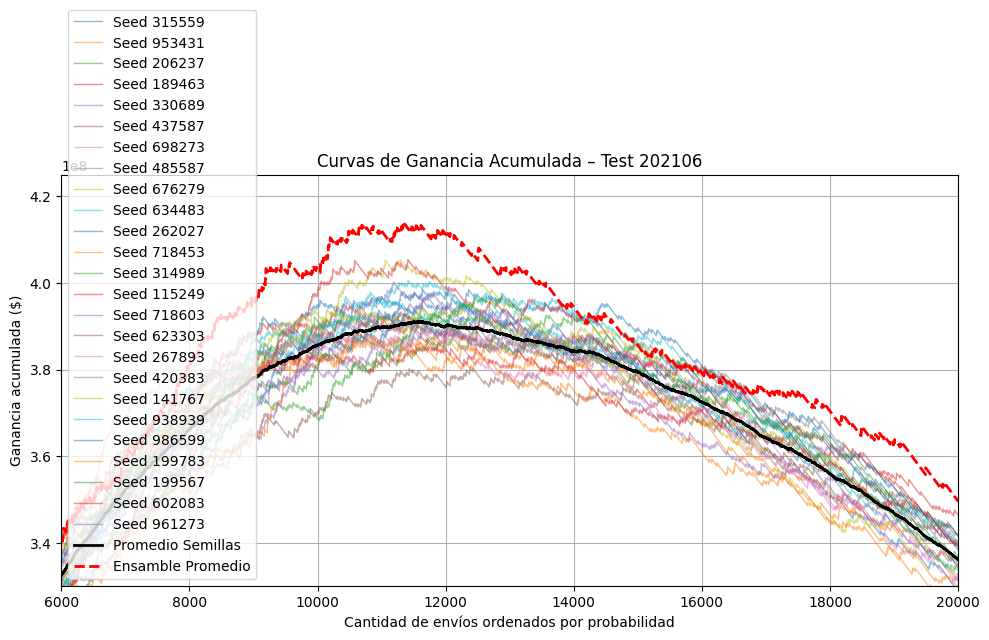

In [46]:
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import gc
import numpy as np
import polars as pl

# ==========================
# 1️⃣ Dataset de test 202106
# ==========================
dataset_test = df.filter(pl.col("foto_mes") == 202106).with_columns(
    pl.when(pl.col("clase_ternaria") == "BAJA+2")
      .then(780000.0)
      .otherwise(-20000.0)
      .alias("gan")
)

X_test = dataset_test.select(campos_buenos).to_numpy()
gan_test = dataset_test["gan"].to_numpy()

# ==========================
# 2️⃣ Evaluación multisemilla
# ==========================
curvas_ganancia = []
preds_ensamble = np.zeros(len(gan_test), dtype=float)

print("Evaluando curvas de ganancia sobre 202106...")
for sem in tqdm(PARAM["train_final"]["semillas"], desc="Semillas"):
    arch_modelo = f"./modelitos/mod_{sem}.txt"
    if not os.path.exists(arch_modelo):
        continue

    modelo_final = lgb.Booster(model_file=arch_modelo)
    preds = modelo_final.predict(X_test)
    preds_ensamble += preds

    # Ordenar por probabilidad y calcular ganancia acumulada
    tb_pred = pl.DataFrame({"gan": gan_test, "prob": preds}).sort("prob", descending=True)
    tb_pred = tb_pred.with_columns(pl.col("gan").cum_sum().alias("gan_acum"))
    curvas_ganancia.append(tb_pred["gan_acum"].to_numpy())

    del modelo_final
    gc.collect()

# ==========================
# 3️⃣ Ensamble promedio
# ==========================
preds_ensamble /= len(PARAM["train_final"]["semillas"])
tb_ensamble = pl.DataFrame({"gan": gan_test, "prob": preds_ensamble}).sort("prob", descending=True)
tb_ensamble = tb_ensamble.with_columns(pl.col("gan").cum_sum().alias("gan_acum"))
gan_ensamble = tb_ensamble["gan_acum"].to_numpy()

# ==========================
# 4️⃣ Plot de curvas
# ==========================
plt.figure(figsize=(10, 6))
x_axis = np.arange(1, len(gan_ensamble) + 1)

# Curvas individuales
for i, curva in enumerate(curvas_ganancia):
    plt.plot(x_axis[:len(curva)], curva, lw=1, alpha=0.5, label=f"Seed {PARAM['train_final']['semillas'][i]}")

# Promedio y ensamble
gan_promedio = np.mean(np.vstack(curvas_ganancia), axis=0)
plt.plot(x_axis, gan_promedio, color="black", lw=2, label="Promedio Semillas")
plt.plot(x_axis, gan_ensamble, color="red", lw=2, ls="--", label="Ensamble Promedio")

# Ajustes de ejes (puedes modificarlos)
plt.xlim(6000, 20000)  # rango de envíos visual
plt.ylim(330000000, 425000000)

plt.title("Curvas de Ganancia Acumulada – Test 202106")
plt.xlabel("Cantidad de envíos ordenados por probabilidad")
plt.ylabel("Ganancia acumulada ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### Clasificación

In [50]:
# Crear carpeta para los envíos (submissions)
os.makedirs("kaggle", exist_ok=True)

# Ordenar por probabilidad descendente
tb_prediccion = tb_prediccion.sort_values(by="prob", ascending=False).reset_index(drop=True)

# Número de envíos
envios = 10500

# Crear columna Predicted (0 por defecto, 1 para los primeros 11k)
tb_prediccion["Predicted"] = 0
tb_prediccion.loc[:envios - 1, "Predicted"] = 1
#PARAM["experimento"] = "seg-009"
# Construir nombre de archivo de salida
archivo_kaggle = f"./kaggle/KA{PARAM['experimento']}_{envios}.csv"

# Guardar archivo final para Kaggle
tb_prediccion[["numero_de_cliente", "Predicted"]].to_csv(
    archivo_kaggle, sep=",", index=False
)

print(f"Archivo generado: {archivo_kaggle}")

Archivo generado: ./kaggle/KAseg-015_10500.csv


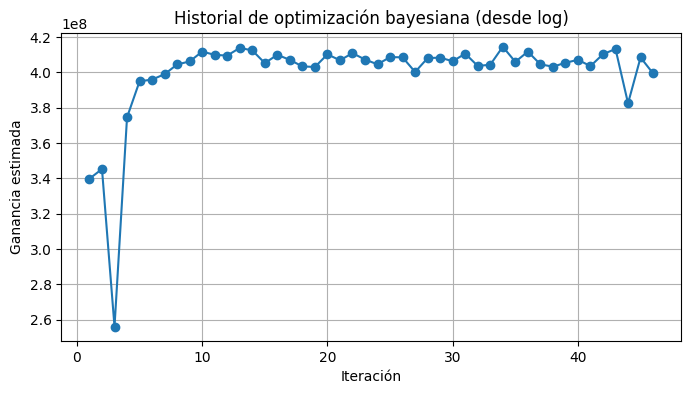

/home/lucasmaestria294/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/lucasmaestria294/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


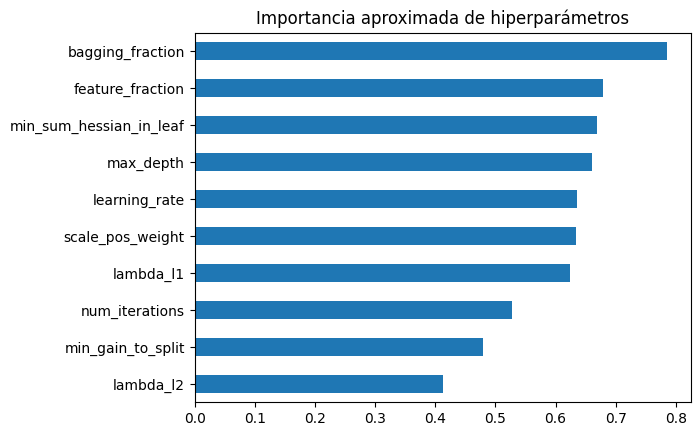

In [48]:
import polars as pl
import matplotlib.pyplot as plt

# Leer log de la bayesiana
tb_BO = pl.read_csv("BO_log_ksemillerio2.txt", separator="\t")

# Evolución de la métrica
plt.figure(figsize=(8,4))
plt.plot(tb_BO["iter"], tb_BO["metrica"], marker="o", linestyle="-")
plt.xlabel("Iteración")
plt.ylabel("Ganancia estimada")
plt.title("Historial de optimización bayesiana (desde log)")
plt.grid(True)
plt.show()

# Importancia de hiperparámetros (simple correlación absoluta)
corrs = (
    tb_BO.drop(["iter", "metrica_mejor", "metrica_sd", "metrica"])
    .to_pandas()
    .select_dtypes(include="number")                      # ← solo numéricas
    .corrwith(tb_BO.to_pandas()["metrica"])
    .abs()
    .sort_values(ascending=False)
)


corrs.head(10).plot.barh(title="Importancia aproximada de hiperparámetros")
plt.gca().invert_yaxis()
plt.show()

shape: (10, 2)
┌─────────────────────────────────┬─────────────────┐
│ feature                         ┆ importance_prom │
│ ---                             ┆ ---             │
│ str                             ┆ f64             │
╞═════════════════════════════════╪═════════════════╡
│ ratio_Visa_mpagominimo_mpayrol… ┆ 431513.447357   │
│ ratio_Visa_mpagominimo_mpayrol… ┆ 358954.978149   │
│ rf_003_004                      ┆ 212784.975028   │
│ rf_014_002                      ┆ 149433.582831   │
│ rf_018_015                      ┆ 136674.15822    │
│ mtarjeta_visa_consumo_ranked    ┆ 120013.454795   │
│ rf_004_004                      ┆ 108533.716495   │
│ ctrx_quarter_normalizado_ranke… ┆ 107834.932145   │
│ rf_001_004                      ┆ 92071.472817    │
│ mcaja_ahorro_ranked             ┆ 85229.974272    │
└─────────────────────────────────┴─────────────────┘


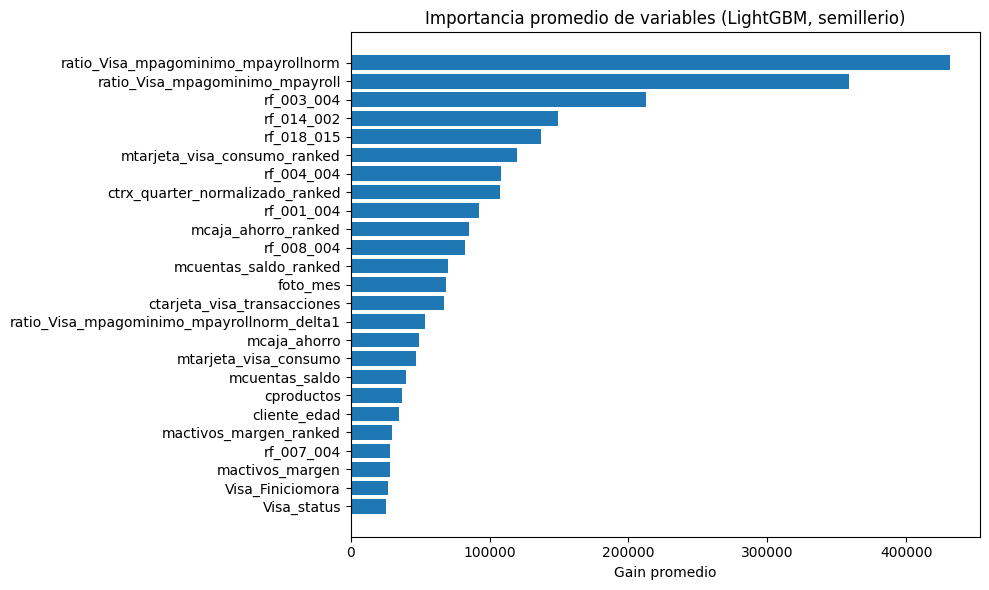

In [64]:
import lightgbm as lgb
import polars as pl
import glob
import os
import gc
import matplotlib.pyplot as plt

# Cargar modelos entrenados
model_paths = sorted(glob.glob("./modelitos/mod_*.txt"))

lista_importancias = []
for path in model_paths:
    model = lgb.Booster(model_file=path)
    imp = pl.DataFrame({
        "feature": model.feature_name(),
        "importance": model.feature_importance(importance_type="gain"),
        "modelo": os.path.basename(path),
    })
    lista_importancias.append(imp)
    del model
    gc.collect()

importancias_pl = pl.concat(lista_importancias)

# Promedio entre modelos (semillas)
imp_media = (
    importancias_pl
    .group_by("feature")
    .agg(pl.col("importance").mean().alias("importance_prom"))
    .sort("importance_prom", descending=True)
    
)

print(imp_media.head(10))

# Graficar
df_plot = imp_media.head(25).to_pandas()
plt.figure(figsize=(10,6))
plt.barh(df_plot["feature"], df_plot["importance_prom"])
plt.gca().invert_yaxis()
plt.title("Importancia promedio de variables (LightGBM, semillerio)")
plt.xlabel("Gain promedio")
plt.tight_layout()
plt.show()

In [ ]:
imp_media202106=imp_media

In [67]:
imp_media.write_csv("./importancia_grande_202108.csv")

In [66]:
imp_media

feature,importance_prom
str,f64
"""ratio_Visa_mpagominimo_mpayrol…",431513.447357
"""ratio_Visa_mpagominimo_mpayrol…",358954.978149
"""rf_003_004""",212784.975028
"""rf_014_002""",149433.582831
"""rf_018_015""",136674.15822
…,…
"""rf_002_008""",0.0
"""rf_003_010""",0.0
"""Visa_Finiciomora_delta2""",0.0
